In [ ]:
from google.colab import drive
drive.mount('/content/drive')
TRAIN_PATH = "/content/drive/MyDrive/Vehicle_dataset/split_data/train"
TEST_PATH = "/content/drive/MyDrive/Vehicle_dataset/split_data/test"
VAL_PATH = "/content/drive/MyDrive/Vehicle_dataset/split_data/validation"

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
from skimage import feature
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pickle
from tqdm import tqdm

In [ ]:
class LocalBinaryPatterns:
    def __init__(self, numPoints=24, radius=3):
        """
        numPoints: số điểm lân cận
        radius: bán kính
        """
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        """
        Tính toán LBP histogram cho ảnh
        """
        # Tính LBP
        lbp = feature.local_binary_pattern(image,
                                          self.numPoints,
                                          self.radius,
                                          method="uniform")

        # Tính histogram
        (hist, _) = np.histogram(lbp.ravel(),
                                bins=np.arange(0, self.numPoints + 3),
                                range=(0, self.numPoints + 2))

        # Chuẩn hóa histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        return hist

In [ ]:
def load_dataset(data_path, image_size=(128, 128)):
    """
    Load dataset từ thư mục
    Structure: data_path/class_name/images.jpg
    """
    data = []
    labels = []

    # Lấy danh sách các class (thư mục con)
    classes = [d for d in os.listdir(data_path)
               if os.path.isdir(os.path.join(data_path, d))]

    print(f"Found {len(classes)} classes: {classes}")

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                      if f.endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Loading {len(image_files)} images from {class_name}...")

        for img_file in tqdm(image_files):
            img_path = os.path.join(class_path, img_file)

            try:
                # Đọc ảnh
                image = cv2.imread(img_path)

                if image is None:
                    continue

                # Resize
                image = cv2.resize(image, image_size)

                # Chuyển sang grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                data.append(gray)
                labels.append(class_name)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

    return np.array(data), np.array(labels)

In [ ]:
def extract_features(images, lbp_descriptor):
    """
    Trích xuất LBP features cho tất cả ảnh
    """
    features = []

    print("Extracting LBP features...")
    for image in tqdm(images):
        hist = lbp_descriptor.describe(image)
        features.append(hist)

    return np.array(features)

In [ ]:
# Load dataset
print("=" * 50)
print("LOADING DATASET")
print("=" * 50)

X_train_img, y_train = load_dataset(TRAIN_PATH, image_size=(128, 128))
X_valid_img, y_valid = load_dataset(VAL_PATH, image_size=(128, 128))
X_test_img,  y_test  = load_dataset(TEST_PATH, image_size=(128, 128))

print(f"Train: {len(X_train_img)}")
print(f"Valid: {len(X_valid_img)}")
print(f"Test : {len(X_test_img)}")

# Initialize LBP descriptor
lbp_desc = LocalBinaryPatterns(numPoints=24, radius=3)

X_train = extract_features(X_train_img, lbp_desc)
X_valid = extract_features(X_valid_img, lbp_desc)
X_test  = extract_features(X_test_img, lbp_desc)

print("Train features:", X_train.shape)
print("Valid features:", X_valid.shape)
print("Test features :", X_test.shape)


# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc  = le.transform(y_test)


total = len(X_train) + len(X_valid) + len(X_test)

print(f"Training samples: {len(X_train)} ({len(X_train)/total*100:.1f}%)")
print(f"Validation samples: {len(X_valid)} ({len(X_valid)/total*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/total*100:.1f}%)")
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


# Train SVM with GridSearch
print("\n" + "=" * 50)
print("TRAINING SVM")
print("=" * 50)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'linear']
}

svm = SVC(random_state=42)

# GridSearch với validation set
grid_search = GridSearchCV(svm, param_grid, cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=2)

grid_search.fit(X_train_scaled, y_train_enc)

print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
# Validation
y_valid_pred = best_model.predict(X_valid_scaled)
valid_acc = accuracy_score(y_valid_enc, y_valid_pred)
print("Validation accuracy:", valid_acc)


LOADING DATASET
Found 7 classes: ['Auto Rickshaws', 'Trains', 'Ships', 'Planes', 'Motorcycles', 'Cars', 'Bikes']
Loading 592 images from Auto Rickshaws...


100%|██████████| 592/592 [00:19<00:00, 30.59it/s]


Loading 640 images from Trains...


100%|██████████| 640/640 [00:18<00:00, 34.25it/s]


Loading 640 images from Ships...


100%|██████████| 640/640 [00:59<00:00, 10.69it/s]


Loading 621 images from Planes...


100%|██████████| 621/621 [00:22<00:00, 27.10it/s]


Loading 639 images from Motorcycles...


100%|██████████| 639/639 [00:11<00:00, 56.09it/s] 


Loading 632 images from Cars...


100%|██████████| 632/632 [00:11<00:00, 56.34it/s] 


Loading 640 images from Bikes...


100%|██████████| 640/640 [00:14<00:00, 44.70it/s] 


Found 7 classes: ['Ships', 'Trains', 'Planes', 'Motorcycles', 'Bikes', 'Cars', 'Auto Rickshaws']
Loading 80 images from Ships...


100%|██████████| 80/80 [00:27<00:00,  2.90it/s]


Loading 80 images from Trains...


100%|██████████| 80/80 [00:19<00:00,  4.05it/s]


Loading 78 images from Planes...


100%|██████████| 78/78 [00:21<00:00,  3.65it/s]


Loading 80 images from Motorcycles...


100%|██████████| 80/80 [00:17<00:00,  4.45it/s]


Loading 80 images from Bikes...


100%|██████████| 80/80 [00:20<00:00,  3.87it/s]


Loading 78 images from Cars...


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


Loading 76 images from Auto Rickshaws...


100%|██████████| 76/76 [00:18<00:00,  4.21it/s]


Found 7 classes: ['Ships', 'Trains', 'Planes', 'Motorcycles', 'Auto Rickshaws', 'Cars', 'Bikes']
Loading 80 images from Ships...


100%|██████████| 80/80 [00:27<00:00,  2.94it/s]


Loading 80 images from Trains...


100%|██████████| 80/80 [00:21<00:00,  3.71it/s]


Loading 76 images from Planes...


100%|██████████| 76/76 [00:18<00:00,  4.07it/s]


Loading 80 images from Motorcycles...


100%|██████████| 80/80 [00:19<00:00,  4.15it/s]


Loading 73 images from Auto Rickshaws...


100%|██████████| 73/73 [00:17<00:00,  4.26it/s]


Loading 79 images from Cars...


100%|██████████| 79/79 [00:17<00:00,  4.64it/s]


Loading 80 images from Bikes...


100%|██████████| 80/80 [00:19<00:00,  4.18it/s]


Train: 4404
Valid: 552
Test : 548
Extracting LBP features...


100%|██████████| 4404/4404 [00:50<00:00, 86.91it/s] 


Extracting LBP features...


100%|██████████| 552/552 [00:05<00:00, 104.05it/s]


Extracting LBP features...


100%|██████████| 548/548 [00:06<00:00, 80.43it/s] 


Train features: (4404, 26)
Valid features: (552, 26)
Test features : (548, 26)
Training samples: 4404 (80.0%)
Validation samples: 552 (10.0%)
Testing samples: 548 (10.0%)

TRAINING SVM
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV score: 0.5653965019089877
Validation accuracy: 0.5887681159420289



EVALUATION ON TEST SET
Test accuracy: 0.5529197080291971

Classification Report:
                precision    recall  f1-score   support

Auto Rickshaws       0.45      0.38      0.41        73
         Bikes       0.83      0.62      0.71        80
          Cars       0.50      0.44      0.47        79
   Motorcycles       0.59      0.61      0.60        80
        Planes       0.65      0.68      0.67        76
         Ships       0.48      0.54      0.51        80
        Trains       0.45      0.57      0.50        80

      accuracy                           0.55       548
     macro avg       0.56      0.55      0.55       548
  weighted avg       0.57      0.55      0.55       548



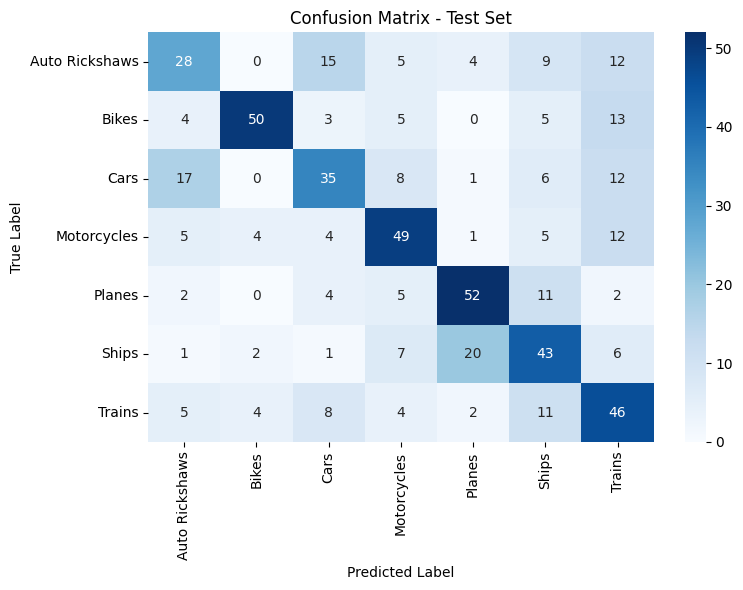


Per-class Accuracy:
Auto Rickshaws: 0.3836
Bikes: 0.6250
Cars: 0.4430
Motorcycles: 0.6125
Planes: 0.6842
Ships: 0.5375
Trains: 0.5750

SUMMARY
Training samples: 4404 (used for training)
Validation samples: 552 - Accuracy: 0.5888
Test samples: 548 - Accuracy: 0.5529


In [ ]:
# Predictions on TEST set
print("\n" + "=" * 50)
print("EVALUATION ON TEST SET")
print("=" * 50)

# Test
y_test_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test_enc, y_test_pred)
print("Test accuracy:", test_acc)

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_test_enc,
    y_test_pred,
    target_names=le.classes_
))


# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(le.classes_):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{class_name}: {class_acc:.4f}")

# Summary of all sets
print("\n" + "=" * 50)
print("SUMMARY")
print("=" * 50)
print(f"Training samples: {len(X_train)} (used for training)")
print(f"Validation samples: {len(X_valid)} - Accuracy: {valid_acc:.4f}")
print(f"Test samples: {len(X_test)} - Accuracy: {test_acc:.4f}")


Correct samples: 303
Wrong samples: 245


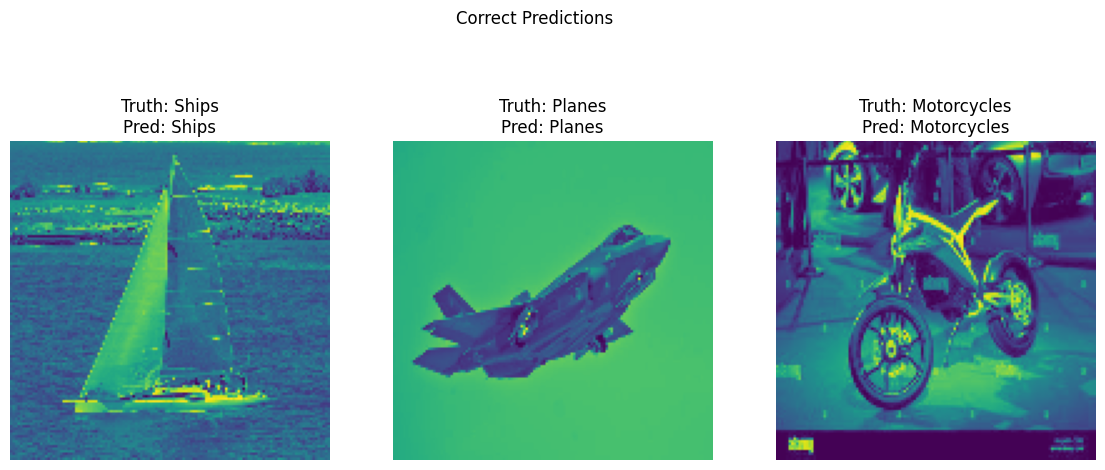

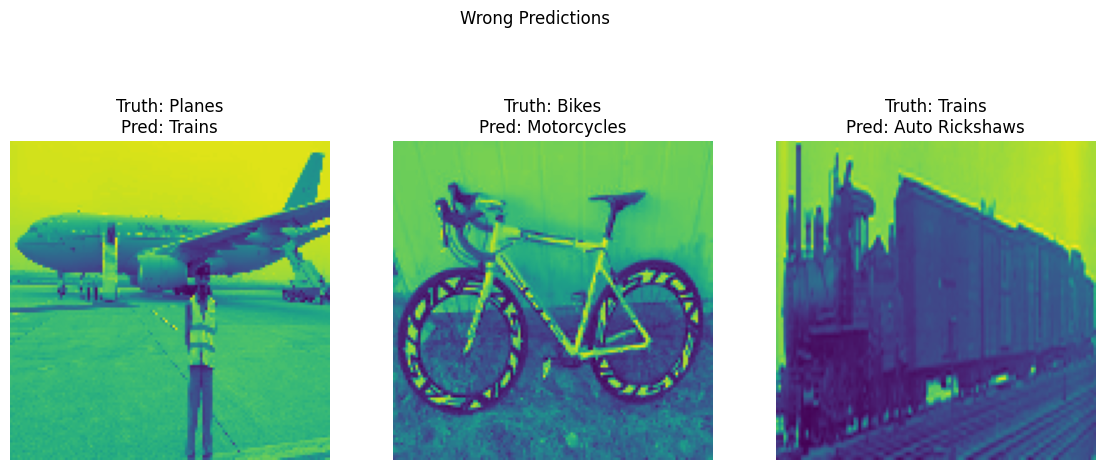

In [ ]:
y_test_pred = best_model.predict(X_test_scaled)

correct_idx = []
wrong_idx = []

for i in range(len(y_test_enc)):
    if y_test_pred[i] == y_test_enc[i]:
        correct_idx.append(i)
    else:
        wrong_idx.append(i)

print("Correct samples:", len(correct_idx))
print("Wrong samples:", len(wrong_idx))

import random

num_show = 3

correct_samples = random.sample(correct_idx, min(num_show, len(correct_idx)))
wrong_samples   = random.sample(wrong_idx,   min(num_show, len(wrong_idx)))

import matplotlib.pyplot as plt

def show_images(indices, title):
    plt.figure(figsize=(14, 6))
    for i, idx in enumerate(indices):
        img = X_test_img[idx]

        true_label = le.inverse_transform([y_test_enc[idx]])[0]
        pred_label = le.inverse_transform([y_test_pred[idx]])[0]

        plt.subplot(1, len(indices), i+1)
        plt.imshow(img)
        plt.axis("off")

        plt.title(f"Truth: {true_label}\nPred: {pred_label}")

    plt.suptitle(title)
    plt.show()

# Show correct predictions
show_images(correct_samples, "Correct Predictions")

# Show wrong predictions
show_images(wrong_samples, "Wrong Predictions")
